In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable

n = 30
train_x = torch.zeros(int(pow(n, 2)), 2)
train_y = torch.zeros(int(pow(n, 2)))
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n - 1)
        train_x[i * n + j][1] = float(j) / (n - 1)
        train_y[i * n + j] = pow(-1, int(3 * i / n + int(3 * j / n)))
train_x = Variable(train_x)
train_y = Variable(train_y)

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.grid_covar_module = GridInterpolationKernel(self.covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        self.initialize_interpolation_grid(10, [(0, 1), (0, 1)])
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_model = GPClassificationModel()

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    n = 100
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.numpy()
        color = []
        for i in range(len(pred_labels)):
            if pred_labels[i] == 1:
                color.append('y')
            else:
                color.append('r')
        ax.scatter(test_x.data[:, 0].numpy(), test_x.data[:, 1].numpy(), color=color, s=1)
        ax.set_ylim([-0.5, 1.5])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

In [6]:
from gpytorch.inference import Inference
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Find optimal model hyperparameters
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.2)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = posterior_model.forward(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        posterior_model.prior_model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
posterior_model.eval()

/Users/ruihanwu/playground/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/200 - Loss: 113993.766   log_lengthscale: 0.000
Iter 2/200 - Loss: 48429.664   log_lengthscale: -0.200
Iter 3/200 - Loss: 18456.781   log_lengthscale: -0.399
Iter 4/200 - Loss: 10603.420   log_lengthscale: -0.590
Iter 5/200 - Loss: 13016.290   log_lengthscale: -0.779
Iter 6/200 - Loss: 16441.393   log_lengthscale: -0.970
Iter 7/200 - Loss: 13209.969   log_lengthscale: -1.157
Iter 8/200 - Loss: 15203.431   log_lengthscale: -1.343
Iter 9/200 - Loss: 12118.277   log_lengthscale: -1.520
Iter 10/200 - Loss: 6482.872   log_lengthscale: -1.691
Iter 11/200 - Loss: 6897.046   log_lengthscale: -1.848
Iter 12/200 - Loss: 3738.693   log_lengthscale: -1.995
Iter 13/200 - Loss: 4258.187   log_lengthscale: -2.135
Iter 14/200 - Loss: 3495.337   log_lengthscale: -2.266
Iter 15/200 - Loss: 3467.723   log_lengthscale: -2.386
Iter 16/200 - Loss: 3337.340   log_lengthscale: -2.498
Iter 17/200 - Loss: 3811.689   log_lengthscale: -2.601
Iter 18/200 - Loss: 2959.923   log_lengthscale: -2.698
Iter 19/20

Iter 151/200 - Loss: 354.702   log_lengthscale: -4.009
Iter 152/200 - Loss: 337.186   log_lengthscale: -4.009
Iter 153/200 - Loss: 310.953   log_lengthscale: -4.009
Iter 154/200 - Loss: 375.065   log_lengthscale: -4.009
Iter 155/200 - Loss: 340.413   log_lengthscale: -4.009
Iter 156/200 - Loss: 323.932   log_lengthscale: -4.009
Iter 157/200 - Loss: 327.178   log_lengthscale: -4.009
Iter 158/200 - Loss: 327.682   log_lengthscale: -4.009
Iter 159/200 - Loss: 326.822   log_lengthscale: -4.009
Iter 160/200 - Loss: 294.525   log_lengthscale: -4.009
Iter 161/200 - Loss: 316.482   log_lengthscale: -4.009
Iter 162/200 - Loss: 311.905   log_lengthscale: -4.009
Iter 163/200 - Loss: 295.435   log_lengthscale: -4.009
Iter 164/200 - Loss: 308.647   log_lengthscale: -4.009
Iter 165/200 - Loss: 311.232   log_lengthscale: -4.009
Iter 166/200 - Loss: 326.287   log_lengthscale: -4.009
Iter 167/200 - Loss: 312.309   log_lengthscale: -4.009
Iter 168/200 - Loss: 336.700   log_lengthscale: -4.009
Iter 169/2

_VariationalGPPosterior (
  (likelihood): BernoulliLikelihood (
  )
  (prior_model): GPClassificationModel (
    (likelihood): BernoulliLikelihood (
    )
    (mean_module): ConstantMean (
    )
    (covar_module): RBFKernel (
    )
    (grid_covar_module): GridInterpolationKernel (
      (base_kernel_module): RBFKernel (
      )
    )
  )
)

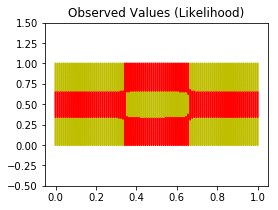

In [7]:
f = plot_model_and_predictions(posterior_model)